# Вычисление площади окружности с помощью метода Монте-Карло

## 1. Подключение модулей

Подключим библиотеку hypersand для вычисления площади. Для простоты hypersand сократим до hs.

Для того, чтобы построить окружность, подключим библиотеки pandas (т.к. основным контейнером данных в hypersand является DataFrame из pandas) и numpy (для легкого манипулирования данными).

In [1]:
import hypersand as hs
import pandas as pd
import numpy as np

## 2. Определение осей

Назовем оси для будущей окружности: "x" и "y":

In [2]:
keys = ["x",
        "y"]

## 3. Генерация данных

Зададим радиус окружности равным 1. Чтобы в фазовой плоскости получилась окружность, вспомним математический анализ.

Уравнение окружности:

x(t) = r * cos(t)  
y(t) = r * sin(t)

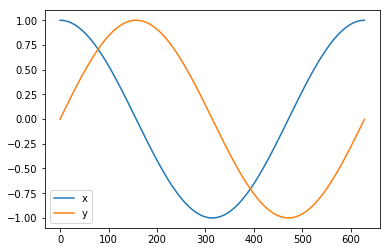

In [3]:
radius = 1
t = np.arange(0, 2 * np.pi, 1e-2)
data = pd.DataFrame()
data[keys[0]] = radius * np.cos(t)
data[keys[1]] = radius * np.sin(t)
data.plot()

## 4. Генерация случайных точек

Сгенерируем 100 случайных точек. Посмотрим, как наш график выглядит в фазовой плоскости. А так же, выведем сгенерированные точки.

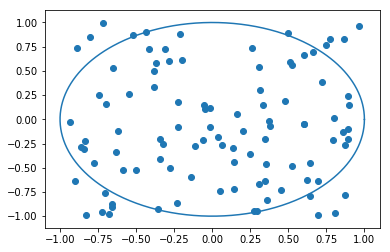

In [4]:
rp = hs.throw_points(data, 100)
hs.plt2d([data, rp], ["plot", "scatter"])

## 5. Пересечения для 0-й точки

Построим прямые, параллельные осям x и y, пересекающие условную 0-ю точку, и найдем точки пересечения этих прямых с фигурой.

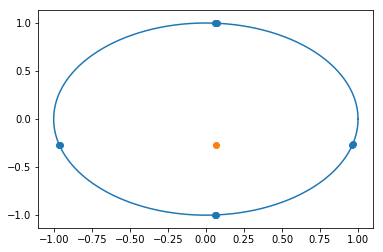

In [5]:
intersections = hs.get_intersections(data, rp.iloc[0], 1e-2)
hs.plt2d([data, intersections, rp.iloc[0]], ["plot", "scatter", "scatter"])

## 6. Определение попаданий

То же самое проделаем со всеми остальными точками. Если точка оказалась вне границ фигуры, будем считать, то она не попала в фигуру. Точность, с которой будем проверять попадания, выберем равной 1e-2.

Важно: вычисления могут занять достаточно долгое время. В данном случае порядка 10 секунд. Время зависит от размерности, общего количества точек в фигуре, количества случайно сгенерированных точек, а так же от производительности процессора.

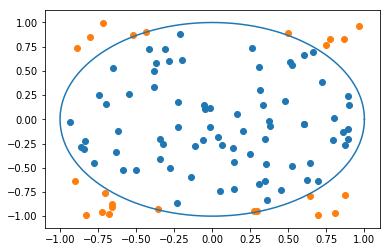

In [6]:
[hits, misses] = hs.hit_analysis(data, rp, 1e-2)
hs.plt2d([data, hits, misses], ["plot", "scatter", "scatter"])

## 7. Вычисление площади

### Вычисленное значение:

Вычислим площадь внутренней части окружности с помощью формулы: площадь фигуры = площадь прямоугольника * количество попаданий / общее количество бросков.

In [7]:
volume = hs.cuboid_volume(data) * len(hits) / len(rp)
print(volume)

3.0399932527946363


Можно было пропустить пункты 5 и 6 - вызвать функцию, которая уже включает в себя операции из пунктов 5 и 6, и получить тот же ответ:

In [8]:
volume = hs.montecarlo(data, rp, 1e-2)
print(volume)

3.0399932527946363


### Теоритическое значение:

Как известно из геометрии, теоретическое значение площади единичной окружности должно быть равно числу $\pi$.

In [9]:
theoretical = np.pi * radius**2
print(theoretical)

3.141592653589793


### Ошибка

Ошибка составляет:

In [10]:
print(theoretical - volume)

0.10159940079515684


## График ошибки для n точек

Построим график ошибки для 1000 точек. То есть, сначала "кинем" одну точку, затем две, и так далее до тысячи.

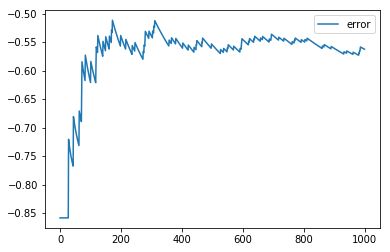

In [11]:
n = 1000

error = []
entries = 0
# Для ускорения вычислений не будем генерировать случайные точки заново, а
# лишь определим попадание для каждой новой точки
for i in range(n):
    randp = hs.throw_points(data, 1) # "кинем" еще одну случайную точку
    ints = hs.get_intersections(data, rp.iloc[0], 1e-2) # получим ее пересечения с окружностью
    flag = True
    for key in keys:
        # определим, попала ли она внутрь окружности
        if not hs.is_hit(ints, randp.iloc[0], key, 1e-2 * 2):
            flag = False
    if flag:
        entries += 1
    
    error.append(theoretical - hs.cuboid_volume(data) * entries / (i + 1))
    
error_df = pd.DataFrame(index=range(n))
error_df["error"] = error

error_df.plot()

Справка из теории: для увеличения точности метода Монте-Карло в 10 раз (на один знак после запятой), нужно увеличить количество точек в 100 раз.